**A/B testing**



*Inspired from work by Elea McDonnell Feit, Professor at Drexel University*

In [15]:
# Advanced AB Testing

## Load libraries
library(tidyverse)
library(ggplot2)

# Test data
d <- read.csv("test_data.csv")
head(d)

user_id,cpgn_id,group,email,open,click,purch,chard,sav_blanc,syrah,cab,past_purch,days_since,visits
1000001,1901Email,ctrl,FALSE,0,0,0.00,0.00,0.00,33.94,0.00,33.94,119,11
1000002,1901Email,email_B,TRUE,1,0,0.00,0.00,0.00,16.23,76.31,92.54,60,3
1000003,1901Email,email_A,TRUE,1,1,200.51,516.39,0.00,16.63,0.00,533.02,9,9
1000004,1901Email,email_A,TRUE,1,0,0.00,0.00,0.00,0.00,41.21,41.21,195,6
1000005,1901Email,email_A,TRUE,1,1,158.30,426.53,1222.48,0.00,0.00,1649.01,48,9
1000006,1901Email,email_B,TRUE,1,0,0.00,0.00,0.00,0.00,0.00,0.00,149,6


In [16]:
# Randomization checks
baseline_check <- d %>%
  group_by(group) %>%
  summarize(
    mean_days_since = mean(days_since),
    mean_visits = mean(visits),
    mean_past_purch = mean(past_purch)
  )
baseline_check

group,mean_days_since,mean_visits,mean_past_purch
ctrl,89.97907,5.948536,188.2670
email_A,90.16635,5.945147,188.4494
email_B,89.80846,5.943478,189.6635


**Baseline variables are distributed similarly for the treatment and control groups.**

Warning message:
"Removed 451 rows containing non-finite values (stat_bin)."Warning message:
"Removed 6 rows containing missing values (geom_bar)."

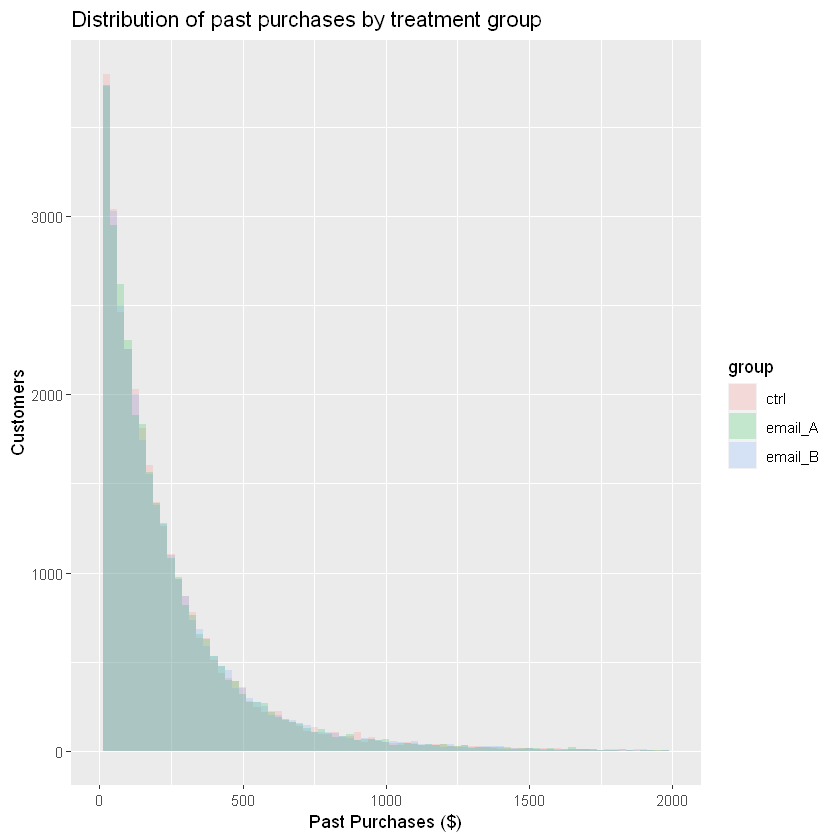

In [17]:
# Visualization: Distribution of past purchases by treatment group
past_purchases_plot <- d %>%
  filter(past_purch > 0) %>%
  ggplot(aes(x = past_purch, fill = group)) + 
  geom_histogram(binwidth = 25, alpha = 0.2, position = "identity") +
  xlim(0, 2000) + 
  xlab("Past Purchases ($)") + ylab("Customers") + 
  labs(title = "Distribution of past purchases by treatment group")
past_purchases_plot

**Distributions of baseline variables should also be the same between treatment groups.**

Warning message:
"Removed 2 rows containing non-finite values (stat_bin)."Warning message:
"Removed 6 rows containing missing values (geom_bar)."

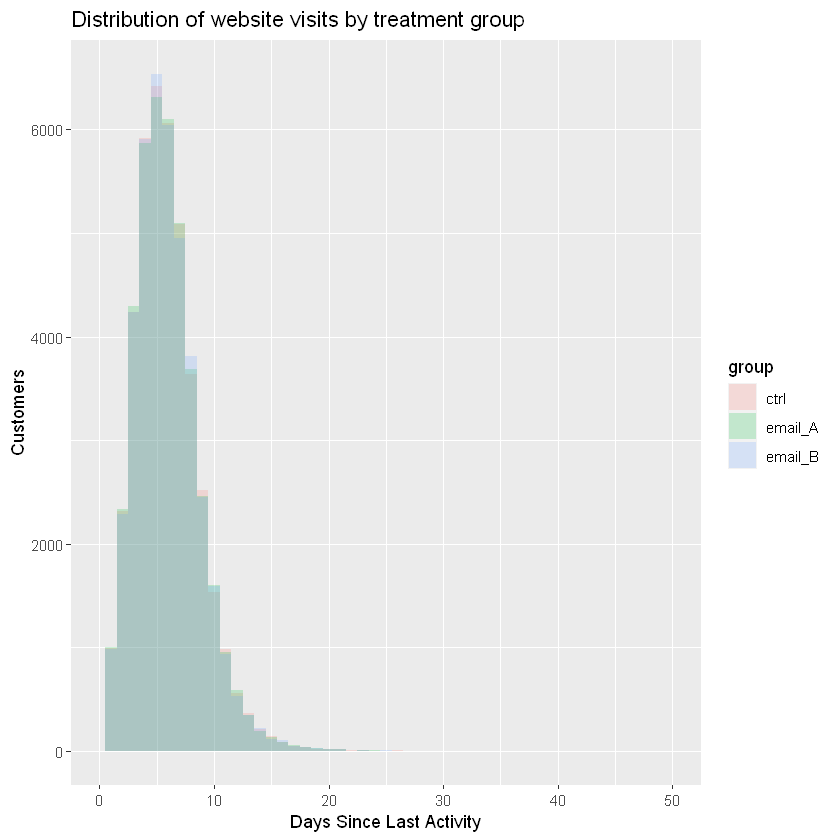

In [23]:
d %>% filter(visits > 0) %>% 
ggplot(aes(x=visits, fill=group)) + 
  geom_histogram(binwidth = 1, alpha=0.2, position="identity") +
  xlim(0, 50) + 
  xlab("Days Since Last Activity") + ylab("Customers") + 
  labs(title="Distribution of website visits by treatment group")

In [4]:
# Randomization checks out! On to the treatment effects.
# Did the treatments affect the responses?
response_summary <- d %>%
  group_by(group) %>%
  summarize(
    mean_open = mean(open),
    mean_click = mean(click),
    mean_purch = mean(purch)
  )
response_summary

group,mean_open,mean_click,mean_purch
ctrl,0.0000000,0.00000000,12.42029
email_A,0.7182850,0.13167509,25.62284
email_B,0.6516974,0.09342108,25.86629


**Email A looks better for opens and clicks, but maybe not purchases. Both emails seem to generate higher average purchases than the control.**

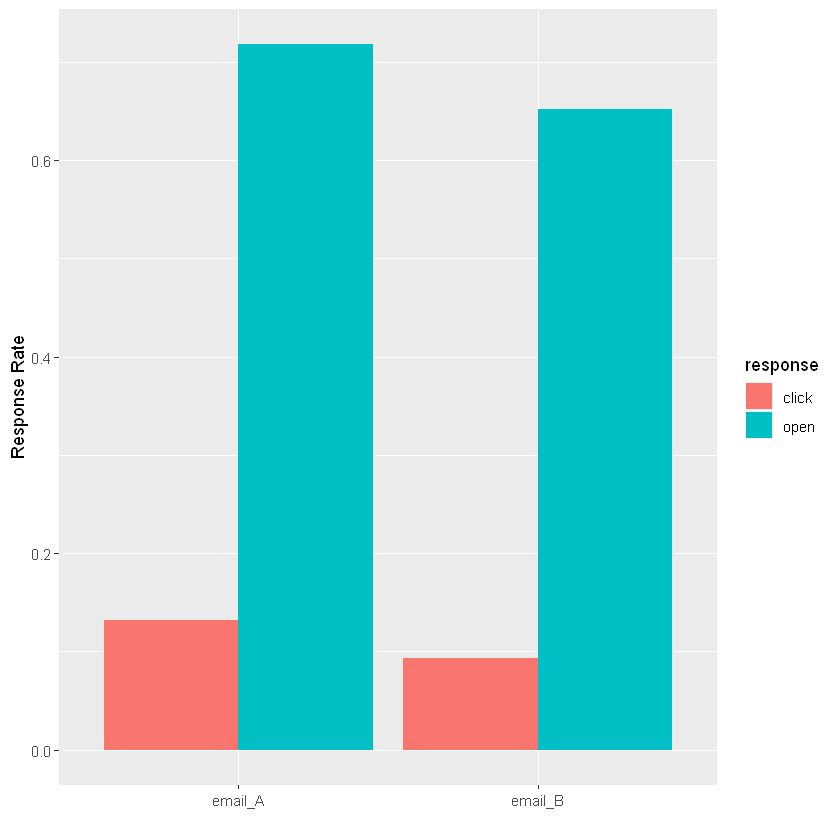

In [5]:
# Visualization: barplot of clicks and opens for emails A & B
response_plot <- d %>%
  filter(group != "ctrl") %>%
  group_by(group) %>%
  summarize(open = mean(open), click = mean(click)) %>%
  gather(response, mean, -group) %>%
  ggplot(aes(fill = response, y = mean, x = group)) + 
  geom_bar(position = "dodge", stat = "identity") + 
  ylab("Response Rate") + xlab("")
response_plot


In [6]:
# Test significance with a t-test
t_test_result <- t.test(purch ~ group, data = d[d$group != "ctrl",])
t_test_result


	Welch Two Sample t-test

data:  purch by group
t = -0.59169, df = 82644, p-value = 0.5541
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.0498820  0.5629813
sample estimates:
mean in group email_A mean in group email_B 
             25.62284              25.86629 


# Summary of findings
**Email A has significantly higher opens and clicks than email B, but purchases are similar for both emails.**
**Both emails generate higher average purchases than the control.**


**Sample Size Planning to achieve the specified power given the effect size, standard deviation, and desired level of significance.**

In [29]:
power.t.test(sd=sd(d$purch), delta=1, sig.level=0.95, power=0.80)


     Two-sample t test power calculation 

              n = 4916.513
          delta = 1
             sd = 54.82613
      sig.level = 0.95
          power = 0.8
    alternative = two.sided

NOTE: n is number in *each* group


**To detect a difference of 1 unit in the mean between the two groups with a standard deviation of approximately 54.83 and a power of 80%, you would need approximately 4917 observations in each group.**

**Sample size calculation required for a proportion-based A/B test** 

In [30]:
# Sample size calculator
power.prop.test(p1=0.07, p2=0.07 + 0.01, sig.level=0.05, power=0.80)


     Two-sample comparison of proportions power calculation 

              n = 10889.14
             p1 = 0.07
             p2 = 0.08
      sig.level = 0.05
          power = 0.8
    alternative = two.sided

NOTE: n is number in *each* group


**To detect a difference of 1% in the conversion rates between the two groups with a baseline conversion rate of 7% in the control group and an expected conversion rate of 8% in the treatment group, we would need approximately 10889.14 observations in each group to achieve a power of 0.8 with a significance level of 0.05.**